Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Image loaded successfully!


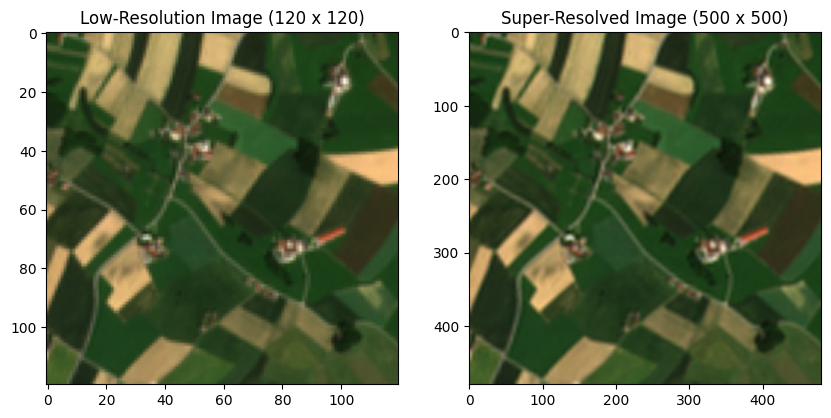

PSNR: 54.63603840852413
SSIM: 0.9978501220787972
MSE: 0.22360243055555556
High-resolution image saved at /content/drive/My Drive/Output/upscaled_image_bicubic.png


In [ ]:
# High-level Bicubic Interpolation Model

import cv2
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import numpy as np
import os
from google.colab import drive

# lr = low resolution
# output = high resolution

# mount Google Drive
drive.mount('/content/drive')

# perform bicubic interpolation
def bicubic_interpolation(lr_image, scale=4):
    # get the size of the new high-resolution image (output image)
    output_size = (lr_image.shape[1] * scale, lr_image.shape[0] * scale)

    # use bicubic interpolation
    output_image = cv2.resize(lr_image, output_size, interpolation=cv2.INTER_CUBIC)
    return output_image

# define the image path correctly with Google Drive path
lr_image_path = '/content/drive/My Drive/LR Images/LR IMAGE 2.png'

# make sure the image is loaded correctly
lr_image = cv2.imread(lr_image_path)
if lr_image is None:
    print(f"Error: Unable to load image at {lr_image_path}")
else:
    print("Image loaded successfully!")

    # perform bicubic interpolation
    output_image = bicubic_interpolation(lr_image)

    # display images side by side
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(lr_image, cv2.COLOR_BGR2RGB))
    plt.title('Low-Resolution Image (120 x 120)')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.title('Super-Resolved Image (500 x 500)')

    plt.show()

    # change images to grayscale for PSNR, SSIM, and MSE evaluation
    lr_image_gray = cv2.cvtColor(lr_image, cv2.COLOR_BGR2GRAY)
    gray_output_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2GRAY)

    # resize the low-resolution image to match the size of the high-resolution (output) image
    resized_lr_image = cv2.resize(lr_image_gray, (gray_output_image.shape[1], gray_output_image.shape[0]), interpolation=cv2.INTER_CUBIC)

    # compute PSNR and SSIM using the resized low-resolution image and high-resolution image
    psnr_value = peak_signal_noise_ratio(resized_lr_image, gray_output_image)
    ssim_value = structural_similarity(resized_lr_image, gray_output_image)

    # calculate MSE
    mse_value = np.mean((resized_lr_image - gray_output_image) ** 2)

    print(f"PSNR: {psnr_value}")
    print(f"SSIM: {ssim_value}")
    print(f"MSE: {mse_value}")

    # output folder and path in Google Drive
    output_folder = '/content/drive/My Drive/Output'

    # full output path (output_folder + filename)
    output_path = os.path.join(output_folder, 'upscaled_image_bicubic.png')

    # make sure the output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)  # Create the folder if it doesn't exist

    # Save upscaled image at the output_path (in Google Drive)
    save_success = cv2.imwrite(output_path, output_image)
    if save_success:
        print(f"High-resolution image saved at {output_path}")
    else:
        print(f"Error: Unable to save image at {output_path}")


<ipython-input-4-1eb0b33439fd>:69: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dst[j, i, c] = np.dot(np.dot(mat_l, mat_m), mat_r)
Progress: 0.01%

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Image loaded successfully!
Start manual bicubic interpolation


Progress: 100.00%


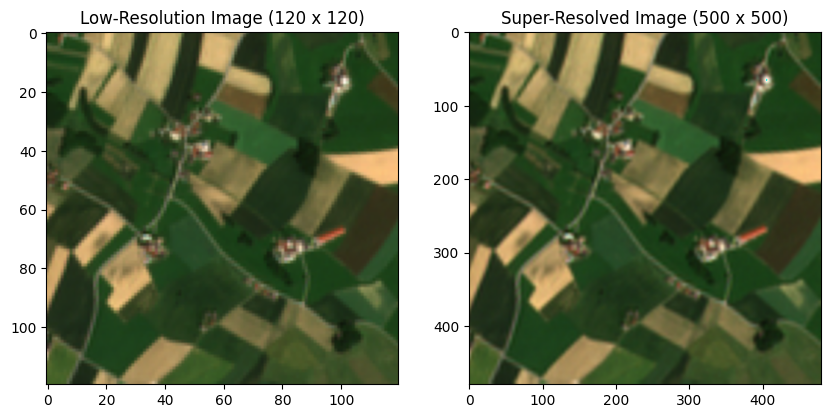

PSNR: 29.65052283960466
SSIM: 0.9238749309048876
MSE: 23.63275173611111
High-resolution image saved at /content/drive/My Drive/Output/upscaled_image_manual_bicubic.png


In [ ]:
# Low-level Bicubic Interpolation Model

import cv2
import numpy as np
import math
import sys, time
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import os
from google.colab import drive

# mount google drive
drive.mount('/content/drive')

# interpolation kernel
def u(s, a):
    if (abs(s) >= 0) & (abs(s) <= 1):
        return (a+2)*(abs(s)**3)-(a+3)*(abs(s)**2)+1
    elif (abs(s) > 1) & (abs(s) <= 2):
        return a*(abs(s)**3)-(5*a)*(abs(s)**2)+(8*a)*abs(s)-4*a
    return 0

# padding
def padding(img, H, W, C):
    zimg = np.zeros((H + 4, W + 4, C))
    zimg[2:H+2, 2:W+2, :C] = img
    # Pad first/last two columns and rows
    zimg[2:H+2, 0:2, :C] = img[:, 0:1, :C]
    zimg[H+2:H+4, 2:W+2, :] = img[H-1:H, :, :]
    zimg[2:H+2, W+2:W+4, :] = img[:, W-1:W, :]
    zimg[0:2, 2:W+2, :C] = img[0:1, :, :C]
    # Pad missing corners
    zimg[0:2, 0:2, :C] = img[0, 0, :C]
    zimg[H+2:H+4, 0:2, :C] = img[H-1, 0, :C]
    zimg[H+2:H+4, W+2:W+4, :C] = img[H-1, W-1, :C]
    zimg[0:2, W+2:W+4, :C] = img[0, W-1, :C]
    return zimg

# manual bicubic interpolation
def bicubic(img, ratio, a=-1/2):
    #image size
    H, W, C = img.shape
    img = padding(img, H, W, C)
    #new image
    dH = math.floor(H * ratio)
    dW = math.floor(W * ratio)
    dst = np.zeros((dH, dW, 3))
    h = 1 / ratio

    print('Start manual bicubic interpolation')
    inc = 0
    for c in range(C):
        for j in range(dH):
            for i in range(dW):
                x, y = i * h + 2, j * h + 2
                x1, x2 = 1 + x - math.floor(x), x - math.floor(x)
                x3, x4 = math.floor(x) + 1 - x, math.floor(x) + 2 - x
                y1, y2 = 1 + y - math.floor(y), y - math.floor(y)
                y3, y4 = math.floor(y) + 1 - y, math.floor(y) + 2 - y

                mat_l = np.matrix([[u(x1, a), u(x2, a), u(x3, a), u(x4, a)]])
                mat_m = np.matrix([[img[int(y - y1), int(x - x1), c], img[int(y - y2), int(x - x1), c],
                                    img[int(y + y3), int(x - x1), c], img[int(y + y4), int(x - x1), c]],
                                   [img[int(y - y1), int(x - x2), c], img[int(y - y2), int(x - x2), c],
                                    img[int(y + y3), int(x - x2), c], img[int(y + y4), int(x - x2), c]],
                                   [img[int(y - y1), int(x + x3), c], img[int(y - y2), int(x + x3), c],
                                    img[int(y + y3), int(x + x3), c], img[int(y + y4), int(x + x3), c]],
                                   [img[int(y - y1), int(x + x4), c], img[int(y - y2), int(x + x4), c],
                                    img[int(y + y3), int(x + x4), c], img[int(y + y4), int(x + x4), c]]])
                mat_r = np.matrix([[u(y1, a)], [u(y2, a)], [u(y3, a)], [u(y4, a)]])
                dst[j, i, c] = np.dot(np.dot(mat_l, mat_m), mat_r)

                # print progress
                inc += 1
                sys.stderr.write('\r\033[KProgress: {:.2f}%'.format(inc / (C * dH * dW) * 100))
                sys.stderr.flush()
    sys.stderr.write('\n')
    sys.stderr.flush()
    return dst

# define the image path
lr_image_path = '/content/drive/My Drive/LR Images/LR IMAGE 2.png'

# make sure image loaded correctly
lr_image = cv2.imread(lr_image_path)
if lr_image is None:
    print(f"Error: Unable to load image at {lr_image_path}")
else:
    print("Image loaded successfully!")

    # do manual bicubic interpolation
    output_image = bicubic(lr_image, ratio=4)

    # change BGR to RGB for correct color display
    rgb_lr_image = cv2.cvtColor(lr_image, cv2.COLOR_BGR2RGB)
    rgb_output_image = cv2.cvtColor(output_image.astype(np.uint8), cv2.COLOR_BGR2RGB)

    # display images side by side
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(rgb_lr_image)
    plt.title('Low-Resolution Image (120 x 120)')

    plt.subplot(1, 2, 2)
    plt.imshow(rgb_output_image)
    plt.title('Super-Resolved Image (500 x 500)')

    plt.show()

    # change image to grayscale for evaluation
    lr_image_gray = cv2.cvtColor(lr_image, cv2.COLOR_BGR2GRAY)
    output_image_gray = cv2.cvtColor(output_image.astype(np.uint8), cv2.COLOR_BGR2GRAY)

    # resize the low-resolution image to match the size of the upscaled high-resolution image
    lr_image_resized = cv2.resize(lr_image_gray, (output_image_gray.shape[1], output_image_gray.shape[0]), interpolation=cv2.INTER_CUBIC)

    # calculate PSNR and SSIM using resized low-resolution image and high-resolution image
    psnr_value = peak_signal_noise_ratio(lr_image_resized, output_image_gray)
    ssim_value = structural_similarity(lr_image_resized, output_image_gray)

    # calculate MSE
    mse_value = np.mean((lr_image_resized - output_image_gray) ** 2)

    print(f"PSNR: {psnr_value}")
    print(f"SSIM: {ssim_value}")
    print(f"MSE: {mse_value}")

    # output folder and path in Google Drive
    output_folder = '/content/drive/My Drive/Output'
    output_path = os.path.join(output_folder, 'upscaled_image_manual_bicubic.png')

    # check output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)  # Create the folder if it doesn't exist

    # save upscaled image at the output_path (in Google Drive)
    save_success = cv2.imwrite(output_path, rgb_output_image)
    if save_success:
        print(f"High-resolution image saved at {output_path}")
    else:
        print(f"Error: Unable to save image at {output_path}")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')